Loading the embedding data (train, test, and validation) for running different models and optimizing hyperparameters, followed by evaluating the test set and presenting the results.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- 1. Load embeddings and labels saved previously ---
from google.colab import drive
drive.mount('/content/drive')

load_path = '/content/drive/MyDrive/my_embeddings_folder_cubes/'

X_train = np.load(load_path + 'best_train_embeddings.npy')
y_train = np.load(load_path + 'train_labels.npy')
X_test = np.load(load_path + 'test_embeddings.npy')
y_test = np.load(load_path + 'test_labels.npy')
X_val = np.load(load_path + 'val_embeddings.npy')
y_val = np.load(load_path + 'val_labels.npy')
# === Load best transform name (for display)
with open(load_path + 'best_transform_name.txt', 'r') as f:
    best_transform_name = f.read().strip()

Mounted at /content/drive



Training the different models, testing various hyperparameters, and selecting the best-performing model.

In [ ]:
import joblib

# --- 2. Encode labels: fit on train, transform on val and test ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# --- 3. Define models and parameter grids for grid search ---
classifiers = {
    "LogisticRegression": (LogisticRegression(max_iter=1000), {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"]}),
    "SVM": (SVC(), {"C": [0.1, 1, 10], "gamma": ["scale", "auto"]}),
    "RandomForest": (RandomForestClassifier(), {"n_estimators": [50, 100], "max_depth": [None, 10, 20]}),
    "NaiveBayes": (GaussianNB(), {})
}

# --- 4. Optimization on train set + evaluation on validation set ---
val_results = []
best_params = {}
best_models = {}

# למעקב אחר המודל הכי טוב
best_model = None
best_model_name = None
best_acc = -1

print(f"\nRunning validation for transform: {best_transform_name}")

for clf_name, (clf, grid) in classifiers.items():
    if grid:
        gs = GridSearchCV(clf, grid, cv=3, scoring="accuracy")
        gs.fit(X_train, y_train_enc)
        best = gs.best_estimator_
        best_params[clf_name] = gs.best_params_
    else:
        best = clf.fit(X_train, y_train_enc)
        best_params[clf_name] = {}

    y_pred = best.predict(X_val)
    acc = accuracy_score(y_val_enc, y_pred)
    min_cls = np.bincount(y_val_enc).argmin()
    f1_min = f1_score(y_val_enc, y_pred, labels=[min_cls], average="macro")

    val_results.append({
        "Model": clf_name,
        "Accuracy": acc,
        "F1_Minority": f1_min
    })

    # בדיקה אם זה המודל הכי טוב
    if acc > best_acc:
        best_acc = acc
        best_model = best
        best_model_name = clf_name

# --- 5. Display validation results ---
df_val = pd.DataFrame(val_results).set_index("Model")
print("\nValidation Results for transform:", best_transform_name)
print(df_val.round(3).to_string())

# Print the optimal parameters
print("\nBest hyperparameters:")
for model_name, params in best_params.items():
    print(f"{model_name}: {params}")

# --- 6. Save the best model ---
save_path = f"/content/drive/MyDrive/best_model_cubes{best_model_name}_{best_transform_name}.joblib"
joblib.dump(best_model, save_path)
print(f"\n✅ Best model ({best_model_name}) saved to: {save_path}")



Running validation for transform: resize_50_pad

Validation Results for transform: resize_50_pad
                    Accuracy  F1_Minority
Model                                    
LogisticRegression     0.656        0.720
SVM                    0.641        0.712
RandomForest           0.534        0.647
NaiveBayes             0.580        0.678

Best hyperparameters:
LogisticRegression: {'C': 0.01, 'penalty': 'l2'}
SVM: {'C': 1, 'gamma': 'scale'}
RandomForest: {'max_depth': None, 'n_estimators': 100}
NaiveBayes: {}

✅ Best model (LogisticRegression) saved to: /content/drive/MyDrive/best_model_cubesLogisticRegression_resize_50_pad.joblib


Evaluation of the best trained model on the test set using a confusion matrix and performance metrics.

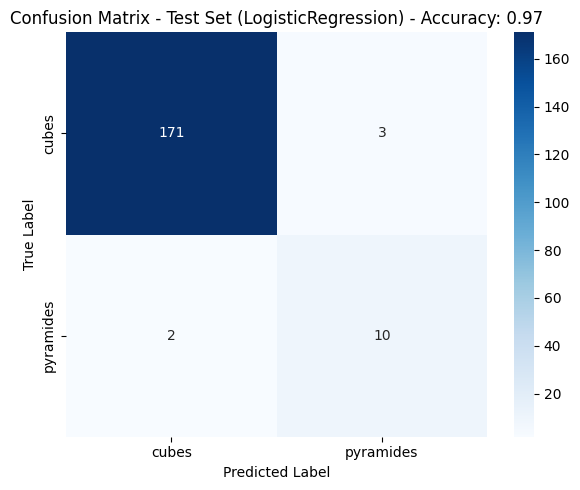


📋 Classification Report for resize_50_pad:

              precision    recall  f1-score   support

       cubes       0.99      0.98      0.99       174
   pyramides       0.77      0.83      0.80        12

    accuracy                           0.97       186
   macro avg       0.88      0.91      0.89       186
weighted avg       0.97      0.97      0.97       186



In [ ]:
import seaborn as sns
# --- 7. Run the best model on the Test set ---
y_test_pred = best_model.predict(X_test)

# --- 8. Show confusion matrix and classification report on Test ---
acc = accuracy_score(y_test_enc, y_test_pred)
cm = confusion_matrix(y_test_enc, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f"Confusion Matrix - Test Set ({best_model_name}) - Accuracy: {acc:.2f}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

report = classification_report(y_test_enc, y_test_pred, target_names=le.classes_)
print(f"\n📋 Classification Report for {best_transform_name}:\n")
print(report)


In [ ]:
def visualize_predictions_with_bboxes(full_image_path, file_paths, predicted_labels, save_path):
    """
    Draws boxes around objects in the image according to the model's predictions.

    Parameters:
    - full_image_path: str, the path to the full image (background)
    - file_paths: list of str, paths to the cropped images (names include coordinates)
    - predicted_labels: list of str/int, the model's predictions (labels)
    - save_path: str, the path to save the image with the boxes
    """
    import cv2
    import re
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    full_image = cv2.imread(full_image_path)
    image_copy = full_image.copy()
    pattern = re.compile(r"cubes_test_(\d+)_(\d+)_(\d+)_(\d+)\.jpg")

    colors = {
            "cubes": (0, 255, 0),      # green
            "pyramides": (225, 0, 0),  # blue
        }

    legend_height = 30 * len(colors)
    legend_width = 200
    legend_img = np.ones((legend_height, legend_width, 3), dtype=np.uint8) * 255

    for i, label in enumerate(colors):
        color = colors[label]
        cv2.rectangle(legend_img, (10, i*30 + 10), (30, i*30 + 30), color, -1)
        cv2.putText(legend_img, f"Class {label}", (40, i*30 + 25),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    for file_path, label in zip(file_paths, predicted_labels):
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            x1, y1, x2, y2 = map(int, match.groups())
            color = colors[label]
            overlay = image_copy.copy()
            cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 2)
            alpha = 1.4
            cv2.addWeighted(overlay, alpha, image_copy, 1 - alpha, 0, image_copy)

    cv2.imwrite(save_path, image_copy)
    image_rgb = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
    legend_rgb = cv2.cvtColor(legend_img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [4, 1]})
    ax[0].imshow(image_rgb)
    ax[0].set_title("Image with Bounding Boxes")
    ax[0].axis('off')

    ax[1].imshow(legend_rgb)
    ax[1].set_title("Class Legend")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()
    print(f"Saved image with bounding boxes to: {save_path}")


Creating bounding boxes (BBOX) for the test set based on the results


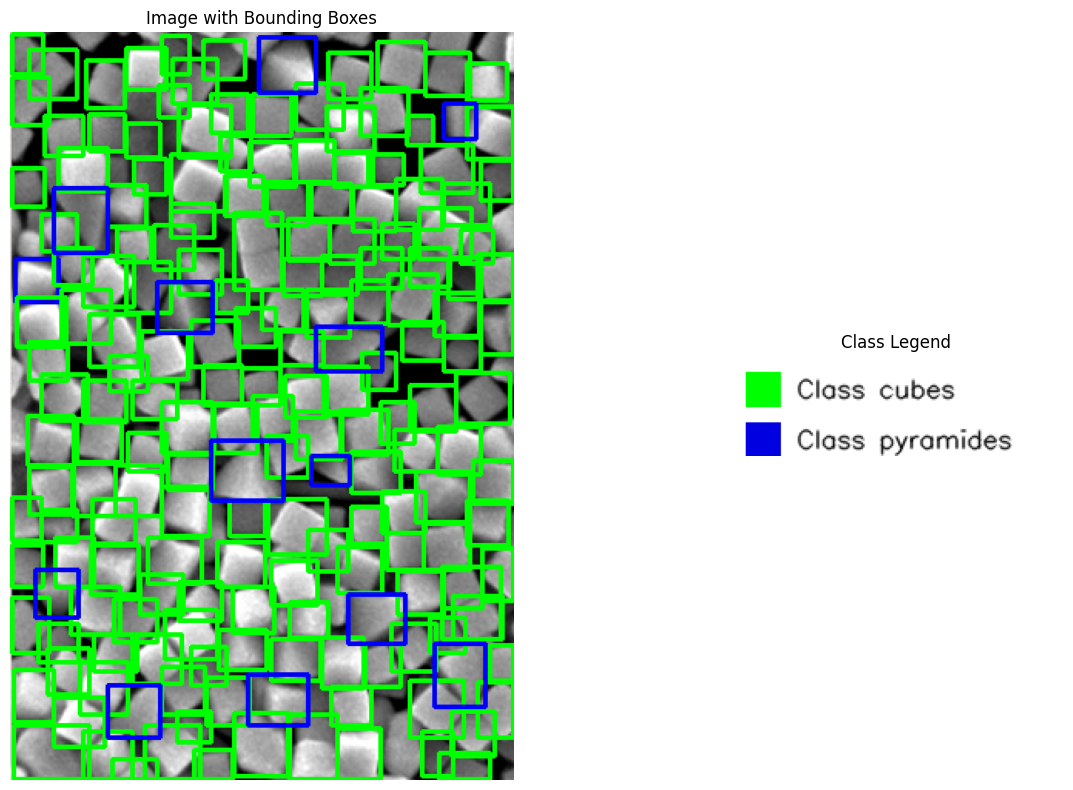

Saved image with bounding boxes to: drive/MyDrive/full_image_with_bboxes_cubes.jpg
visualize_predictions_with_bboxes function called.


In [ ]:
import os
def get_image_paths(dirpath):
    out=[]
    for cl in os.listdir(dirpath):
        cp=os.path.join(dirpath,cl)
        if os.path.isdir(cp):
            out += [os.path.join(cp,f) for f in os.listdir(cp) if f.lower().endswith(('.jpg','.png','.jpeg'))]
    return out

test_image_paths = get_image_paths("/content/drive/MyDrive/cubes_new/test")
visualize_predictions_with_bboxes(
    full_image_path="drive/MyDrive/cubes_test_.jpg",
    save_path="drive/MyDrive/full_image_with_bboxes_cubes.jpg",
    file_paths= test_image_paths,
    predicted_labels = le.inverse_transform(y_test_pred)
)
print("visualize_predictions_with_bboxes function called.")